# Figure 4
Inactivation of RSC reduces reliance on rewarded-choice history and impairs hyperbolic weighting of past trials.

In [1]:
%load_ext autoreload

## General import functions

In [76]:
%reset -f
import sys
from os.path import dirname, join as pjoin
from os import listdir
sys.path.append('C:\\jupyter_notebooks\\Danskin_SciAdv_2023\\py_code') # local directory
import numpy as np
import pickle
import random
import xarray as xr
import pandas as pd

import h5py
import scipy.io as sio
from scipy import stats
import statsmodels as sm # import statsmodels.api as sm
from scipy.optimize import minimize, basinhopping, curve_fit
from sklearn.model_selection import KFold
from tqdm.notebook import tqdm, trange

In [77]:
## Directories
%autoreload
import bdanskin as BD 

project_dir = 'C:\\jupyter_notebooks\\Danskin_SciAdv_2023' # local directory
opto_dir = pjoin(project_dir, 'chr2_optogenetics')
behavior_dir = pjoin(project_dir, 'hattori_datasets_behavior')

In [78]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
fig_save_dir = 'ms_figures_230623'

## General plotting functions

In [79]:
plt_colors = BD.plt_color_dir()
def sem(y):
    if len(np.shape(y))==1:
        return np.nanstd(y)/np.sqrt(len(y)-1)
    else:
        n,_ = np.shape(y)
        return np.nanstd(y,0)/np.sqrt(n-1)

def plt_remove_spines(ax):
    if len(np.shape(ax))>1:
        ax_y, ax_x = np.shape(ax)
        for xx in range(ax_x):
            for yy in range(ax_y):
                ax[yy,xx].spines['top'].set_visible(False)
                ax[yy,xx].spines['right'].set_visible(False)
    else:
        for xx in range(len(ax)):
            ax[xx].spines['top'].set_visible(False)
            ax[xx].spines['right'].set_visible(False)

def stats_compare(y):
    if np.nanmean(y)>0:
        pos_neg = 1
    else:
        pos_neg = -1
        
    _,pnorm = stats.normaltest(y)
    if pnorm<0.05:
        h_norm = 0
        _, pval = stats.wilcoxon(y)
        print('wilcoxon')
    else:
        h_norm = 1
        _, pval = stats.ttest_1samp(y,0.0)
        print('ttest')
        
    h_lvl = 0
    if (pval<0.05) & (pval>=0.01):
        h_lvl = 1
    elif (pval<0.01) & (pval>=0.001):
        h_lvl = 2
    elif (pval<0.001) & (pval>=0.0001):
        h_lvl = 3
    elif (pval<0.0001):
        h_lvl = 4
    return pval, h_lvl, h_norm, pos_neg

def stats_wilcoxon(y):
    if np.nanmean(y)>0:
        pos_neg = 1
    else:
        pos_neg = -1
        
    _, pval = stats.wilcoxon(y)
        
    h_lvl = 0
    if (pval<0.05) & (pval>=0.01):
        h_lvl = 1
    elif (pval<0.01) & (pval>=0.001):
        h_lvl = 2
    elif (pval<0.001) & (pval>=0.0001):
        h_lvl = 3
    elif (pval<0.0001):
        h_lvl = 4
    return pval, h_lvl, pos_neg

def sig_text(pval):
    sig_lvl = 0
    if (pval<0.05) & (pval>=0.01):
        sig_lvl = 1
    elif (pval<0.01) & (pval>=0.001):
        sig_lvl = 2
    elif (pval<0.001) & (pval>=0.0001):
        sig_lvl = 3
    elif (pval<0.0001):
        sig_lvl = 4

    if sig_lvl==4:
        txt_out = '****'
    elif sig_lvl==3:
        txt_out = '***'  
    elif sig_lvl==2:
        txt_out = '**'      
    elif sig_lvl==1:
        txt_out = '*'
    else:
        txt_out = 'n.s.'
    return txt_out

def add_sig_plt(ax,x_ind,y_ind,font_size,pval,sig_lvl,pos_neg):
    plt_clr = 'k'
    if pos_neg==1:
        plt_clr = 'r'
        
    if sig_lvl==-1:    # catch for mixedeffects that have no sig lvl
        sig_lvl = 0
        if (pval<0.05) & (pval>=0.01):
            sig_lvl = 1
        elif (pval<0.01) & (pval>=0.001):
            sig_lvl = 2
        elif (pval<0.001) & (pval>=0.0001):
            sig_lvl = 3
        elif (pval<0.0001):
            sig_lvl = 4

    if sig_lvl==4:
        ax.text(x_ind,y_ind,'****',color=plt_clr,fontsize = font_size, transform = ax.transAxes)
    if sig_lvl==3:
        ax.text(x_ind,y_ind,'***',color=plt_clr,fontsize = font_size, transform = ax.transAxes)  
    if sig_lvl==2:
        ax.text(x_ind,y_ind,'**',color=plt_clr,fontsize = font_size, transform = ax.transAxes)      
    if sig_lvl==1:
        ax.text(x_ind,y_ind,'*',color=plt_clr,fontsize = font_size, transform = ax.transAxes)

## Specific plotting functions

### Extraction functions

#### regression weights

In [80]:
# For RU models
r_ru5_ctrl_inds = slice(0,5)
u_ru5_ctrl_inds = slice(5,10)
r_ru5_opto_inds = slice(10,15)
u_ru5_opto_inds = slice(15,20)

rewc_ctrl_inds = [0,1,2,3,4]
rewc_opto_inds = [10,11,12,13,14]
mouse_colors = {'BD031': [0.9,.2,.1], 'BD032': [0.8,.3,.1], 'BD033': [0.8,.5,.1], 'BD043': [.9,.7,0.1],
                'BD109': [.75,.8,.1], 'BD110': [.5,.8,.1], 'BD111': [.2,.8,.1], 'BD112': [.1,.7,.5],
                'BD113': [.1,.5,.1], 'BD115': [0.1,.6,.6], 'BD116': [.2,.2,.8], 'BD117': [.5,.1,.5],
                'BD118': [.4,.1,.8]}
        
def extract_opto_weights(df, inac_type, area, mdl_type, mdl_penalty, param_name):
    # area: 'RSCb' 'PPCb' 'M2b' 'ALMb' 'Control'
    # mdl_hist: 5
    # mdl_type: 'R' 'RU' 'RC'
    # mdl_penalty: 'none' 'l2'
    # param_name: 'mean_weights' 'median_weights'
    out_df = df.loc[((df['Area']==area) & 
                     (df['Inac Type']==inac_type) & 
                     (df['mdl_type']==mdl_type) &
                     (df['mdl_penalty']==mdl_penalty)),
                    param_name].reset_index(drop=True)
    
    obs_dim = len(out_df)
    coef_dim = len(out_df.iloc[0])
    out_weights = np.zeros([obs_dim, coef_dim])
    for ii in range(obs_dim):
        out_weights[ii,:] = out_df.iloc[ii]
    return out_weights


#### paired weights

In [81]:
def extract_sessionvec_mouseid(mdl_df,param_name,ind):
    all_coef_mat = np.zeros([len(mdl_df),22])
    all_mouse_vec = mdl_df['Mouse'].values
    for nn in range(len(mdl_df)):
        all_coef_mat[nn,:] = mdl_df.iloc[nn].loc[param_name]
    all_coef_vec = all_coef_mat[:,ind]
    coef_df = pd.DataFrame({'coef': all_coef_vec,
                            'Mouse': all_mouse_vec})
    m_id_series = mdl_df['Mouse'].values
    return all_coef_vec, m_id_series

def extract_sessionvec_mouseid_sum(mdl_df,param_name,ind):
    all_coef_mat = np.zeros([len(mdl_df),22])
    all_mouse_vec = mdl_df['Mouse'].values
    for nn in range(len(mdl_df)):
        all_coef_mat[nn,:] = mdl_df.iloc[nn].loc[param_name]
    all_coef_vec = np.sum(np.abs(all_coef_mat[:,ind]),axis=1)
    coef_df = pd.DataFrame({'coef': all_coef_vec,
                            'Mouse': all_mouse_vec})
    m_id_series = mdl_df['Mouse'].values
    return all_coef_vec, m_id_series


def get_rewc1_weights_df(logistic_df_all, area, penalty_type):
    mdl_type='RU'
    param_name = 'mean_weights'
    mdl_df_all = logistic_df_all.loc[(logistic_df_all['Area']==area) &
                                     (logistic_df_all['Inac Type']=='ra') & 
                                     (logistic_df_all['mdl_type']==mdl_type) &
                                     (logistic_df_all['mdl_penalty']==penalty_type)
                                    ].reset_index(drop=True)
    ctrl_y, m_id = extract_sessionvec_mouseid(mdl_df_all,param_name,4)
    opto_y, m_id = extract_sessionvec_mouseid(mdl_df_all,param_name,14)
    plt_df = pd.DataFrame({'ctrl': ctrl_y, 'opto': opto_y, 'mouse_id':m_id})
    
    beta_1 = np.concatenate([ctrl_y, opto_y])
    treatment = np.concatenate([np.zeros(len(ctrl_y)), np.ones(len(ctrl_y))]).astype(int)
    mouse_id = np.concatenate([m_id,m_id])
    session_id = np.concatenate([np.arange(len(ctrl_y)),np.arange(len(ctrl_y))])
    stats_df = pd.DataFrame({'beta_1': beta_1, 'opto': treatment, 
                            'mouse_id':mouse_id, 'session_id':session_id})
    return plt_df, stats_df

def get_sum_weights_df(logistic_df_all, area, penalty_type):
    mdl_type='RU'
    param_name = 'mean_weights'
    mdl_df_all = logistic_df_all.loc[(logistic_df_all['Area']==area) &
                                     (logistic_df_all['Inac Type']=='ra') & 
                                     (logistic_df_all['mdl_type']==mdl_type) &
                                     (logistic_df_all['mdl_penalty']==penalty_type)
                                    ].reset_index(drop=True)

    ctrl_y, m_id = extract_sessionvec_mouseid_sum(mdl_df_all,param_name,rewc_ctrl_inds)
    opto_y, m_id = extract_sessionvec_mouseid_sum(mdl_df_all,param_name,rewc_opto_inds)
    plt_df = pd.DataFrame({'ctrl': ctrl_y, 'opto': opto_y, 'mouse_id':m_id})
    
    beta_1 = np.concatenate([ctrl_y, opto_y])
    treatment = np.concatenate([np.zeros(len(ctrl_y)), np.ones(len(ctrl_y))]).astype(int)
    mouse_id = np.concatenate([m_id,m_id])
    session_id = np.concatenate([np.arange(len(ctrl_y)),np.arange(len(ctrl_y))])
    stats_df = pd.DataFrame({'beta_1': beta_1, 'opto': treatment, 
                            'mouse_id':mouse_id, 'session_id':session_id})
    return plt_df, stats_df

#### mixed effects modeling

In [82]:
import statsmodels.formula.api as smf
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

In [83]:
def weights_stats_compare(logistic_df_all, area, penalty_type, c_ind, o_ind,corr_int = True):
    mdl_type='RU'
    param_name = 'mean_weights'
    mdl_df_all = logistic_df_all.loc[(logistic_df_all['Area']==area) &
                                     (logistic_df_all['Inac Type']=='ra') & 
                                     (logistic_df_all['mdl_type']==mdl_type) &
                                     (logistic_df_all['mdl_penalty']==penalty_type)
                                    ].reset_index(drop=True)
    ctrl_y, m_id = extract_sessionvec_mouseid(mdl_df_all,param_name,c_ind)
    opto_y, m_id = extract_sessionvec_mouseid(mdl_df_all,param_name,o_ind)
    beta_1 = np.concatenate([ctrl_y, opto_y])
    treatment = np.concatenate([np.zeros(len(ctrl_y)), np.ones(len(ctrl_y))]).astype(int)
    mouse_id = np.concatenate([m_id,m_id])
    session_id = np.concatenate([np.arange(len(ctrl_y)),np.arange(len(ctrl_y))])
    stats_df = pd.DataFrame({'beta_1': beta_1, 'opto': treatment, 
                            'mouse_id':mouse_id, 'session_id':session_id})
    if corr_int:
        # Correlated intercept and slope (worse)
        md = smf.mixedlm('beta_1 ~ C(opto)',stats_df, groups=stats_df['mouse_id'], 
                         re_formula='~C(opto)').fit(method='bfgs')
    else: 
        # Independent incercept and slope (better)
        md = smf.mixedlm('beta_1 ~ C(opto)',stats_df, groups=stats_df['mouse_id'],
                         vc_formula = {'opto' : '1 + C(opto)'}).fit(method='cg')
    return md

In [84]:
def weights_stats_compare_sum(logistic_df_all, area, penalty_type, c_inds, o_inds,corr_int = True):
    mdl_type='RU'
    param_name = 'mean_weights'
    mdl_df_all = logistic_df_all.loc[(logistic_df_all['Area']==area) &
                                     (logistic_df_all['Inac Type']=='ra') & 
                                     (logistic_df_all['mdl_type']==mdl_type) &
                                     (logistic_df_all['mdl_penalty']==penalty_type)
                                    ].reset_index(drop=True)
    ctrl_y, m_id = extract_sessionvec_mouseid_sum(mdl_df_all,param_name,c_inds)
    opto_y, m_id = extract_sessionvec_mouseid_sum(mdl_df_all,param_name,o_inds)
    beta_1 = np.concatenate([ctrl_y, opto_y])
    treatment = np.concatenate([np.zeros(len(ctrl_y)), np.ones(len(ctrl_y))]).astype(int)
    mouse_id = np.concatenate([m_id,m_id])
    session_id = np.concatenate([np.arange(len(ctrl_y)),np.arange(len(ctrl_y))])
    stats_df = pd.DataFrame({'beta_1': beta_1, 'opto': treatment, 
                            'mouse_id':mouse_id, 'session_id':session_id})
    if corr_int:
        # Correlated intercept and slope (worse)
        md = smf.mixedlm('beta_1 ~ C(opto)',stats_df, groups=stats_df['mouse_id'], 
                         re_formula='~C(opto)').fit(method='bfgs')
    else: 
        # Independent incercept and slope (better)
        md = smf.mixedlm('beta_1 ~ C(opto)',stats_df, groups=stats_df['mouse_id'],
                         vc_formula = {'opto' : '1 + C(opto)'}).fit(method='cg')
    return md

#### ws/ls mixed effects stats

In [85]:
def get_param_stats_df(df_all, area, inac_type, c_param, o_param):
    plt_df = df_all.loc[(df_all['Area']==area) & (df_all['Inac Type']==inac_type),
                       ['Mouse', c_param, o_param]].reset_index(drop=True)

    plt_df.rename(columns={c_param: 'ctrl', o_param: 'opto'}, inplace=True)
              
    beta_1 = np.concatenate([plt_df['ctrl'], plt_df['opto']])
    treatment = np.concatenate([np.zeros(len(plt_df)), np.ones(len(plt_df))]).astype(int)
    mouse_id = np.concatenate([plt_df['Mouse'],plt_df['Mouse']])
    session_id = np.concatenate([np.arange(len(plt_df)),np.arange(len(plt_df))])
    stats_df = pd.DataFrame({'beta_1': beta_1, 'opto': treatment, 
                            'mouse_id':mouse_id, 'session_id':session_id})
    return plt_df, stats_df


### Plotting subfunctions

#### box plots

In [86]:
def plot_boxplot(ax,x,y,color):
    ax.boxplot(y, positions = [x], widths=0.5, 
               notch=False, showfliers=False, patch_artist=True,
               boxprops=dict(facecolor='none',color=color,linewidth=1.0),
               capprops=dict(color=color,linewidth=1.0),
               whiskerprops=dict(color=color,linewidth=1.0),
               medianprops=dict(color=color,linewidth=1.0))

#### regression weights

In [87]:
## Plot RU outputs
def plot_opto_regression_ru(ax, ax_ind, mean_vec, sem_vec, opto_color):
    n_back = 5
    x_plt = -np.linspace((n_back),1,n_back)
    ax[ax_ind].plot([-11,0], [0,0], c='grey', linewidth=1)
    ax[ax_ind].errorbar(x_plt, mean_vec[r_ru5_ctrl_inds], sem_vec[r_ru5_ctrl_inds],
                     c='k', marker='o', markersize=3, linestyle='-', capsize=4,label='Ctrl')
    ax[ax_ind].errorbar(x_plt, mean_vec[r_ru5_opto_inds], sem_vec[r_ru5_opto_inds],
                     c=opto_color, marker='o', markersize=3, linestyle='-', capsize=4, label='Inac')
    ax[ax_ind].set_xticks(x_plt)
    ax[ax_ind].set_xlim([-5.5,-.5])
    ax[ax_ind].set_yticks([-1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5])
    if ax_ind>0:
        ax[ax_ind].set_yticklabels(['', '', '', '', '', '', '', ''])

#### plot pairs

In [88]:
def plot_pairs(ax, x_inds, y_lim, plt_df):
    m_all = plt_df['mouse_id'].unique()
    for mm in m_all:
        sub_df = plt_df.loc[plt_df['mouse_id']==mm]
        sub_mat = sub_df[['ctrl','opto']].to_numpy().T
        ax.plot(x_inds,sub_mat,c=mouse_colors[mm],alpha=0.85,linewidth=1)
    ax.fill_between([x_inds[1]-.25,x_inds[1]+.25],[y_lim[0],y_lim[0]],[y_lim[1],y_lim[1]],
                    facecolor=plt_colors['opto'],alpha=0.25)
    # ax.errorbar(x_inds,[np.mean(ctrl_vec),np.mean(opto_vec)], [.1,.1],
    #             color='r',capsize=5)
    ax.plot([x_inds[0]-.2,x_inds[0]+.2],[np.median(plt_df['ctrl']),np.median(plt_df['ctrl'])],
            '-r', linewidth=3)
    ax.plot([x_inds[1]-.2,x_inds[1]+.2],[np.median(plt_df['opto']),np.median(plt_df['opto'])],
            '-r', linewidth=3)

#### wsls plotting functions

In [89]:
def plot_wsls_pairs(ax, x_inds, y_lim, plt_df):
    m_all = plt_df['Mouse'].unique()
    for mm in m_all:
        sub_df = plt_df.loc[plt_df['Mouse']==mm]
        sub_mat = sub_df[['ctrl','opto']].to_numpy().T
        ax.plot(x_inds,sub_mat,c=mouse_colors[mm],alpha=0.85,linewidth=1)
    ax.fill_between([x_inds[1]-.25,x_inds[1]+.25],[y_lim[0],y_lim[0]],[y_lim[1],y_lim[1]],
                    facecolor=plt_colors['opto'],alpha=0.25)
    # ax.errorbar(x_inds,[np.mean(ctrl_vec),np.mean(opto_vec)], [.1,.1],
    #             color='r',capsize=5)
    ax.plot([x_inds[0]-.2,x_inds[0]+.2],[np.median(plt_df['ctrl']),np.median(plt_df['ctrl'])],
            '-r', linewidth=3)
    ax.plot([x_inds[1]-.2,x_inds[1]+.2],[np.median(plt_df['opto']),np.median(plt_df['opto'])],
            '-r', linewidth=3)

In [90]:
def plot_wsls_pairs_mixedeffects(ax, y_lim, wsls_df, c_param, o_param):
    rsc_plt_df, rsc_stats_df = get_param_stats_df(wsls_df, 'RSCb', 'ra', c_param, o_param)
    ppc_plt_df, ppc_stats_df = get_param_stats_df(wsls_df, 'PPCb','ra', c_param, o_param)
    m2_plt_df, m2_stats_df = get_param_stats_df(wsls_df, 'M2b','ra', c_param, o_param)

    plot_wsls_pairs(ax, [1,2], y_lim, rsc_plt_df)
    plot_wsls_pairs(ax, [3.5,4.5], y_lim, ppc_plt_df)
    plot_wsls_pairs(ax, [6,7], y_lim, m2_plt_df)
    ax.set_ylim(y_lim);

    pval_vec = np.array([])
    md = smf.mixedlm('beta_1 ~ C(opto)',rsc_stats_df, groups=rsc_stats_df['mouse_id'],
                             vc_formula = {'opto' : '1 + C(opto)'}).fit(method='cg')
    pval = md.pvalues[1]; pval_vec = np.append(pval_vec,pval)
    add_sig_plt(ax,.1,.8,11,pval,-1,0)

    md = smf.mixedlm('beta_1 ~ C(opto)',ppc_stats_df, groups=ppc_stats_df['mouse_id'],
                             vc_formula = {'opto' : '1 + C(opto)'}).fit(method='cg')
    pval = md.pvalues[1]; pval_vec = np.append(pval_vec,pval)
    add_sig_plt(ax,.45,.8,11,pval,-1,0)

    md = smf.mixedlm('beta_1 ~ C(opto)', m2_stats_df, groups=m2_stats_df['mouse_id'],
                             vc_formula = {'opto' : '1 + C(opto)'}).fit(method='cg')
    pval = md.pvalues[1]; pval_vec = np.append(pval_vec,pval)
    add_sig_plt(ax,.8,.8,11,pval,-1,0)
    print(pval_vec)
    
    rsc_delta = (rsc_plt_df['opto'] - rsc_plt_df['ctrl']).values
    ppc_delta = (ppc_plt_df['opto'] - ppc_plt_df['ctrl']).values
    m2_delta = (m2_plt_df['opto'] - m2_plt_df['ctrl']).values

    _,p_rsc_ppc = stats.ttest_ind(rsc_delta, ppc_delta)
    _,p_rsc_m2 = stats.ttest_ind(rsc_delta, m2_delta)
    print('RSC:PPC {0:.5f}, RSC:M2 {1:.5f}'.format(p_rsc_ppc, p_rsc_m2))
    
    add_sig_plt(ax,.25,.91,11,p_rsc_ppc,-1,0)
    add_sig_plt(ax,.25,.98,11,p_rsc_m2,-1,0)
    
    ax.set_xlim(.5,7.5)
    ax.set_xticks([1,2,3.5,4.5,6,7])
    ax.set_xticklabels(['Ctrl','Inac','Ctrl','Inac','Ctrl','Inac'],fontsize=10)
    ax.text(.1, -.26,'RSC',fontsize=11, transform = ax.transAxes)
    ax.text(.45,-.26,'PPC',fontsize=11, transform = ax.transAxes)
    ax.text(.82, -.26,'pM2',fontsize=11, transform = ax.transAxes)

## Load processed data

In [91]:
# Load server data
opto_reg = pd.read_pickle(pjoin(opto_dir, 'logistic_ChR2_l1l2_subsample1000.pkl'))
chr2_ws_ls = pd.read_pickle(pjoin(opto_dir, 'ChR2_wsls.pkl'))

### Regression l1 performance improvement
Reported in methods

In [92]:
opto_area_subset = opto_reg.loc[((opto_reg['Area']=='RSCb') & (opto_reg['Inac Type']=='ra')) |
                                # ((opto_reg['Area']=='RSCb') & (opto_reg['Inac Type']=='iti')) |
                                ((opto_reg['Area']=='PPCb') & (opto_reg['Inac Type']=='ra')) |
                                # ((opto_reg['Area']=='PPCb') & (opto_reg['Inac Type']=='iti')) |
                                ((opto_reg['Area']=='M2b') & (opto_reg['Inac Type']=='ra')) #|
                                # ((opto_reg['Area']=='M2b') & (opto_reg['Inac Type']=='iti')) |
                                # ((opto_reg['Area']=='Control') & (opto_reg['Inac Type']=='ra')) |
                                # ((opto_reg['Area']=='Control') & (opto_reg['Inac Type']=='iti')) 
                               ]

#### [Plt] cv loglik l1 regularization 

wilcoxon
7.731138702428815e-14
medians:-1.69, -0.61; pvalue: 7.73e-14
mean:-2.23+/-0.23; -0.64+/-0.02


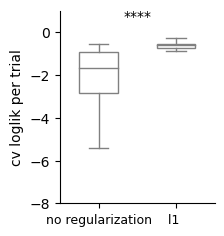

In [93]:
f,ax = plt.subplots(1,1, sharey=False, sharex=False, figsize = [2, 2.5], tight_layout=False)
stats_verbosity = True
temp_df_0 = opto_area_subset.loc[(opto_area_subset['mdl_penalty']=='none')]
temp_df_1 = opto_area_subset.loc[(opto_area_subset['mdl_penalty']=='l1')]

param_name = 'loglik_test'

# # inf correction
# print(sum(df[param_name]==-np.inf))
temp_y0 =  temp_df_0[param_name]; temp_y0 = temp_y0[temp_y0!=-np.inf]
temp_y1 =  temp_df_1[param_name]; temp_y1 = temp_y1[temp_y1!=-np.inf]

n_mouse_0 = len(temp_y0)
n_mouse_1 = len(temp_y1)

        
plot_boxplot(ax, (0), [temp_y0], [.5,.5,.5])
plot_boxplot(ax, (1.0), [temp_y1], [.5,.5,.5])
# ax.plot((0.1)*np.ones(n_mouse_0), temp_y0, 'o', ms=5, 
#              c='k', markerfacecolor='none', label='none')
# ax.plot((1.1)*np.ones(n_mouse_1), temp_y1, 'o', ms=5, 
#              c='k', markerfacecolor='none', label='l1')

## add stats compare
if stats_verbosity:
    pval, sig_lvl, h_norm, pos_neg = stats_compare(temp_df_1[param_name]-temp_df_0[param_name]); 
    pval_vec = pval
    add_sig_plt(ax,0.41,.95,10,pval,sig_lvl,0)
    print(pval_vec)

ax.set_ylim([-8,1]);
ax.set_xticks([0,1]); ax.set_xlim([-.5,1.5]); 
ax.set_xticklabels(['no regularization','l1 '],rotation=0, fontsize=9)
ax.set_ylabel('cv loglik per trial')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
# f.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'4_opto','cv_loglik_l1.png'))
# f.savefig(pjoin(fig_save_dir,'4_opto','cv_loglik_l1.svg'))
print('medians:{0:.2f}, {1:.2f}; pvalue: {2:.2e}'.format(np.nanmedian(temp_y0), np.nanmedian(temp_y1), pval_vec))

print('mean:{0:.2f}+/-{1:.2f}; {2:.2f}+/-{3:.2f}'.format(np.nanmean(temp_y0), sem(temp_y0), 
                                                         np.nanmean(temp_y1), sem(temp_y1),))


### Regression curves

#### [Plt] RewC weights across areas (mixed effects stats on sum)

[0.03740039 0.71846356 0.50962068]


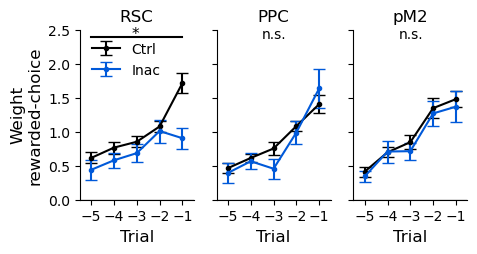

In [94]:
f,ax = plt.subplots(1,3, sharey=False, sharex=False, figsize = [5, 2.5], tight_layout=False)
reg_type = 'l1'; y_lim = np.array([0, 2.5])
inac_type = 'ra'

weights_mat = extract_opto_weights(opto_reg, inac_type, 'RSCb', 'RU',
                              reg_type, 'mean_weights')
mean_vec = np.nanmean(weights_mat,0)
sem_vec = sem(weights_mat)
plot_opto_regression_ru(ax, 0, mean_vec, sem_vec, plt_colors['ChR2'])
ax[0].set_ylim(y_lim)
ax[0].set_title('RSC',fontsize=12)
ax[0].set_ylabel('Weight\nrewarded-choice',fontsize=12)
ax[0].set_xlabel('Trial',fontsize=12)
ax[0].legend(loc='upper left', frameon=False)

weights_mat = extract_opto_weights(opto_reg, inac_type, 'PPCb', 'RU',
                              reg_type, 'mean_weights')
mean_vec = np.nanmean(weights_mat,0)
sem_vec = sem(weights_mat)
plot_opto_regression_ru(ax, 1, mean_vec, sem_vec, plt_colors['ChR2'])
ax[1].set_ylim(y_lim)
ax[1].set_title('PPC',fontsize=12)
ax[1].set_xlabel('Trial',fontsize=12)

weights_mat = extract_opto_weights(opto_reg, inac_type, 'M2b', 'RU',
                              reg_type, 'mean_weights')
mean_vec = np.nanmean(weights_mat,0)
sem_vec = sem(weights_mat)
plot_opto_regression_ru(ax, 2, mean_vec, sem_vec, plt_colors['ChR2'])
ax[2].set_ylim(y_lim)
ax[2].set_title('pM2',fontsize=12)
ax[2].set_xlabel('Trial',fontsize=12)

pval_vec = np.array([])
ax[0].plot([-5,-1],[2.4,2.4],'-k',linewidth=1.5)
md = weights_stats_compare_sum(opto_reg, 'RSCb', 'l1', [0,1,2,3,4],[10,11,12,13,14],corr_int = False)
pval = md.pvalues[1]; pval_vec = np.append(pval_vec,pval)
if pval<0.05:
    add_sig_plt(ax[0],.45,.95,11,pval,-1,0)
else:
    ax[0].text(.4,.95, 'n.s.', fontsize=10, transform = ax[0].transAxes)


md = weights_stats_compare_sum(opto_reg, 'PPCb', 'l1', [0,1,2,3,4],[10,11,12,13,14],corr_int = False)
pval = md.pvalues[1]; pval_vec = np.append(pval_vec,pval)
if pval<0.05:
    add_sig_plt(ax[0],.45,.95,11,pval,-1,0)
else:
    ax[1].text(.4,.95, 'n.s.', fontsize=10, transform = ax[1].transAxes)
    
md = weights_stats_compare_sum(opto_reg, 'M2b', 'l1', [0,1,2,3,4],[10,11,12,13,14],corr_int = False)
pval = md.pvalues[1]; pval_vec = np.append(pval_vec,pval)
if pval<0.05:
    add_sig_plt(ax[0],.45,.95,11,pval,-1,0)
else:
    ax[2].text(.4,.95, 'n.s.', fontsize=10, transform = ax[2].transAxes)
print(pval_vec)

plt_remove_spines(ax)

f.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'4_opto', 'acrossarea_weights_mixedeffects_{}.png'.format(reg_type)))
# f.savefig(pjoin(fig_save_dir,'4_opto','acrossarea_weights_mixedeffects_{}.svg'.format(reg_type)))

#### [Plt] Supplemental, all weights by area

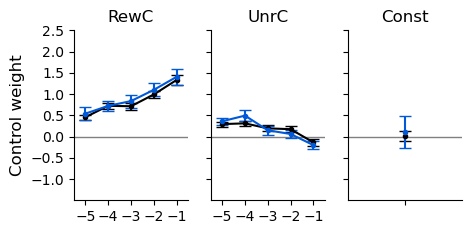

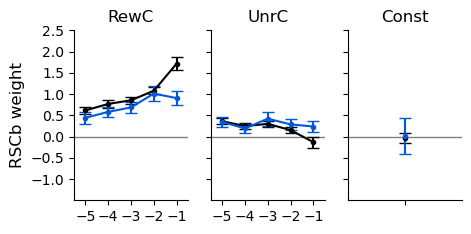

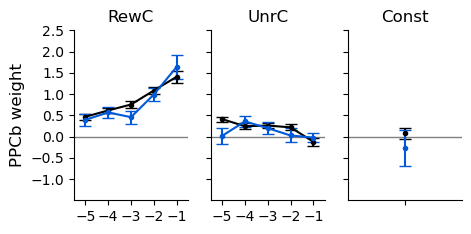

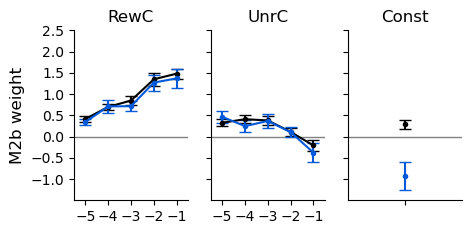

In [95]:
for area in ['Control','RSCb','PPCb','M2b']:
    f,ax = plt.subplots(1,3, sharey=False, sharex=False, figsize = [5, 2.5], tight_layout=False)
    y_lim = np.array([-1.5, 2.5])
    inac_type = 'ra'
    reg_type = 'l1'
    opto_color = plt_colors['ChR2']
    n_back = 5
    x_plt = -np.linspace((n_back),1,n_back)

    weights_mat = extract_opto_weights(opto_reg, inac_type, area, 'RU',
                                  reg_type, 'mean_weights')
    mean_vec = np.nanmean(weights_mat,0)
    sem_vec = sem(weights_mat)

    ax[0].plot([-11,0], [0,0], c='grey', linewidth=1)
    ax[0].errorbar(x_plt, mean_vec[r_ru5_ctrl_inds], sem_vec[r_ru5_ctrl_inds],
                     c='k', marker='o', markersize=3, linestyle='-', capsize=4,label='Ctrl')
    ax[0].errorbar(x_plt, mean_vec[r_ru5_opto_inds], sem_vec[r_ru5_opto_inds],
                     c=opto_color, marker='o', markersize=3, linestyle='-', capsize=4, label='Opto')
    ax[0].set_title('RewC')
    ax[0].set_ylabel('{} weight'.format(area),fontsize=12)
    ax[0].set_xticks(x_plt)
    ax[0].set_xlim([-5.5,-.5])
    ax[0].set_yticks([-1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5])
    ax[0].set_ylim(y_lim)

    ax[1].plot([-11,0], [0,0], c='grey', linewidth=1)
    ax[1].errorbar(x_plt, mean_vec[u_ru5_ctrl_inds], sem_vec[u_ru5_ctrl_inds],
                     c='k', marker='o', markersize=3, linestyle='-', capsize=4,label='Ctrl')
    ax[1].errorbar(x_plt, mean_vec[u_ru5_opto_inds], sem_vec[u_ru5_opto_inds],
                     c=opto_color, marker='o', markersize=3, linestyle='-', capsize=4, label='Opto')
    ax[1].set_title('UnrC')
    ax[1].set_xticks(x_plt)
    ax[1].set_xlim([-5.5,-.5])
    ax[1].set_yticks([-1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5])
    ax[1].set_yticklabels(['', '', '', '', '', '', '', ''])
    ax[1].set_ylim(y_lim)

    ax[2].plot([-11,0], [0,0], c='grey', linewidth=1)
    ax[2].errorbar(-5, mean_vec[-1], sem_vec[-1],
                     c='k', marker='o', markersize=3, linestyle='-',capsize=4)
    ax[2].errorbar(-5, mean_vec[-2], sem_vec[-2],
                     c=opto_color, marker='o', markersize=3, linestyle='-', capsize=4)
    ax[2].set_title('Const')
    ax[2].set_xticks([-5]); ax[2].set_xticklabels([''])
    ax[2].set_xlim([-6,-4])
    ax[2].set_yticks([-1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5])
    ax[2].set_yticklabels(['','','','','','','',''])
    ax[2].set_ylim(y_lim)

    plt_remove_spines(ax)

    f.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=None, hspace=None)
    # f.savefig(pjoin(fig_save_dir,'4_opto', '{}_RU_weights_{}.png'.format(area,reg_type)))
    # f.savefig(pjoin(fig_save_dir,'4_opto','{}_RU_weights_{}.svg'.format(area,reg_type)))

### Regression weights paired plots

#### [Plt] Paired RewC(t-1) (session) with mixed effects

[1.72472523e-04 3.68246826e-01 7.01753312e-01]
RSC:PPC 0.00099, RSC:M2 0.00724


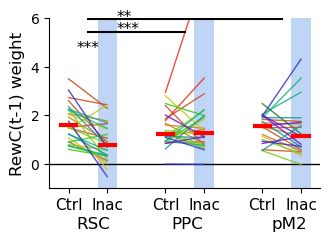

In [96]:
f,ax = plt.subplots(1,1, figsize = [3.5, 2.5], tight_layout=False)
reg_type = 'l1'; y_lim = [-1,6]
# reg_type = 'none'; y_lim = [-5,80]
rsc_plt_df, rsc_stats_df = get_rewc1_weights_df(opto_reg, 'RSCb',reg_type)
ppc_plt_df, ppc_stats_df = get_rewc1_weights_df(opto_reg, 'PPCb',reg_type)
m2_plt_df, m2_stats_df = get_rewc1_weights_df(opto_reg, 'M2b',reg_type)

ax.plot([-.5,10],[0,0],'-k',linewidth=1)
plot_pairs(ax, [1,2], y_lim, rsc_plt_df)
plot_pairs(ax, [3.5,4.5], y_lim, ppc_plt_df)
plot_pairs(ax, [6,7], y_lim, m2_plt_df)

pval_vec = np.array([])
md = weights_stats_compare(opto_reg, 'RSCb', reg_type, 4,14,corr_int = False)
pval = md.pvalues[1]; pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax,.1,.8,11,pval,-1,0)
md = weights_stats_compare(opto_reg, 'PPCb', reg_type, 4,14,corr_int = False)
pval = md.pvalues[1]; pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax,.45,.8,11,pval,-1,0)
md = weights_stats_compare(opto_reg, 'M2b', reg_type, 4,14,corr_int = False)
pval = md.pvalues[1]; pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax,.8,.8,11,pval,-1,0)
print(pval_vec)

rsc_delta = (rsc_plt_df['opto'] - rsc_plt_df['ctrl']).values
ppc_delta = (ppc_plt_df['opto'] - ppc_plt_df['ctrl']).values
m2_delta = (m2_plt_df['opto'] - m2_plt_df['ctrl']).values
# t-test
_,p_rsc_ppc = stats.ttest_ind(rsc_delta, ppc_delta)
_,p_rsc_m2 = stats.ttest_ind(rsc_delta, m2_delta)
print('RSC:PPC {0:.5f}, RSC:M2 {1:.5f}'.format(p_rsc_ppc, p_rsc_m2))

if reg_type=='l1':
    add_sig_plt(ax,.25,.91,11,p_rsc_ppc,-1,0)
    ax.plot([1.5,4.0],[5.45,5.45],'-k',linewidth=1.5)
    add_sig_plt(ax,.25,.98,11,p_rsc_m2,-1,0)
    ax.plot([1.5,6.5],[5.95,5.95],'-k',linewidth=1.5)
else:
    add_sig_plt(ax,.25,.91,11,p_rsc_ppc,-1,0)
    ax.plot([1.5,4.0],[73,73],'-k',linewidth=1.5)
    add_sig_plt(ax,.25,.98,11,p_rsc_m2,-1,0)
    ax.plot([1.5,6.5],[79.5,79.5],'-k',linewidth=1.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('RewC(t-1) weight',fontsize=12)
ax.set_ylim(y_lim)
ax.set_xlim(.5,7.5)
ax.set_xticks([1,2,3.5,4.5,6,7])
ax.set_xticklabels(['Ctrl','Inac','Ctrl','Inac','Ctrl','Inac'],fontsize=11)
ax.text(.1, -.24,'RSC',fontsize=12, transform = ax.transAxes)
ax.text(.45,-.24,'PPC',fontsize=12, transform = ax.transAxes)
ax.text(.82, -.24,'pM2',fontsize=12, transform = ax.transAxes)
f.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'4_opto','acrossarea_rewc1_mixedeffects_{}.png'.format(reg_type)))
# f.savefig(pjoin(fig_save_dir,'4_opto','acrossarea_rewc1_mixedeffects_{}.svg'.format(reg_type)))

#### [Plt] Paired sum(RewC) (session) with mixed effects

[0.03740039 0.71846356 0.50962068]
RSC:PPC 0.04, RSC:M2 0.12


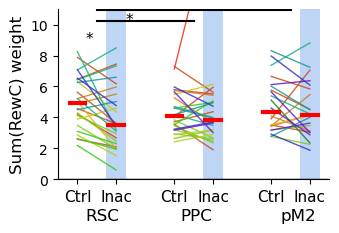

In [97]:
f,ax = plt.subplots(1,1, figsize = [3.5, 2.5], tight_layout=False)
reg_type = 'l1'; y_lim = [0,11]
# reg_type = 'none'; y_lim = [0,200]
rsc_plt_df, rsc_stats_df = get_sum_weights_df(opto_reg, 'RSCb',reg_type)
ppc_plt_df, ppc_stats_df = get_sum_weights_df(opto_reg, 'PPCb',reg_type)
m2_plt_df, m2_stats_df = get_sum_weights_df(opto_reg, 'M2b',reg_type)

ax.plot([-.5,10],[0,0],'-k',linewidth=1)
plot_pairs(ax, [1,2], y_lim, rsc_plt_df)
plot_pairs(ax, [3.5,4.5], y_lim, ppc_plt_df)
plot_pairs(ax, [6,7], y_lim, m2_plt_df)

pval_vec = np.array([])
md = weights_stats_compare_sum(opto_reg, 'RSCb', reg_type, [0,1,2,3,4],[10,11,12,13,14],corr_int = False)
pval = md.pvalues[1]; pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax,.1,.8,11,pval,-1,0)
md = weights_stats_compare_sum(opto_reg, 'PPCb', reg_type, [0,1,2,3,4],[10,11,12,13,14],corr_int = False)
pval = md.pvalues[1]; pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax,.45,.8,11,pval,-1,0)
md = weights_stats_compare_sum(opto_reg, 'M2b', reg_type, [0,1,2,3,4],[10,11,12,13,14],corr_int = False)
pval = md.pvalues[1]; pval_vec = np.append(pval_vec,pval)
add_sig_plt(ax,.8,.8,11,pval,-1,0)
print(pval_vec)

rsc_delta = (rsc_plt_df['opto'] - rsc_plt_df['ctrl']).values
ppc_delta = (ppc_plt_df['opto'] - ppc_plt_df['ctrl']).values
m2_delta = (m2_plt_df['opto'] - m2_plt_df['ctrl']).values
# ttest
_,p_rsc_ppc = stats.ttest_ind(rsc_delta, ppc_delta)
_,p_rsc_m2 = stats.ttest_ind(rsc_delta, m2_delta)
print('RSC:PPC {0:.2f}, RSC:M2 {1:.2f}'.format(p_rsc_ppc, p_rsc_m2))

if reg_type=='l1':
    add_sig_plt(ax,.25,.91,11,p_rsc_ppc,-1,0)
    ax.plot([1.5,4],[10.25,10.25],'-k',linewidth=1.5)
    add_sig_plt(ax,.25,.98,11,p_rsc_m2,-1,0)
    ax.plot([1.5,6.5],[10.95,10.95],'-k',linewidth=1.5)
else: 
    # no regularization
    add_sig_plt(ax,.25,.91,11,p_rsc_ppc,-1,0)
    ax.plot([1.5,4],[185,185],'-k',linewidth=1.5)
    add_sig_plt(ax,.25,.98,11,p_rsc_m2,-1,0)
    ax.plot([1.5,6.5],[199,199],'-k',linewidth=1.5)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.set_ylabel('Sum(RewC) weight',fontsize=12)
ax.set_ylim(y_lim)
ax.set_xlim(.5,7.5)
ax.set_xticks([1,2,3.5,4.5,6,7])
ax.set_xticklabels(['Ctrl','Inac','Ctrl','Inac','Ctrl','Inac'],fontsize=11)
ax.text(.1, -.24,'RSC',fontsize=12, transform = ax.transAxes)
ax.text(.45,-.24,'PPC',fontsize=12, transform = ax.transAxes)
ax.text(.82, -.24,'pM2',fontsize=12, transform = ax.transAxes)
f.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'4_opto','acrossarea_sum_mixedeffects_{}.png'.format(reg_type)))
# f.savefig(pjoin(fig_save_dir,'4_opto','acrossarea_sum_mixedeffects_{}.svg'.format(reg_type)))

### Winstay, loseswitch

#### [Plt] winstay_stay, loseswitch_switch

C:\Users\Bethanny\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


[0.00072178 0.60113388 0.3075764 ]
RSC:PPC 0.00142, RSC:M2 0.00174


C:\Users\Bethanny\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)
C:\Users\Bethanny\Anaconda3\lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


[1.02827948e-04 6.05833837e-01 8.19625311e-01]
RSC:PPC 0.00109, RSC:M2 0.00508


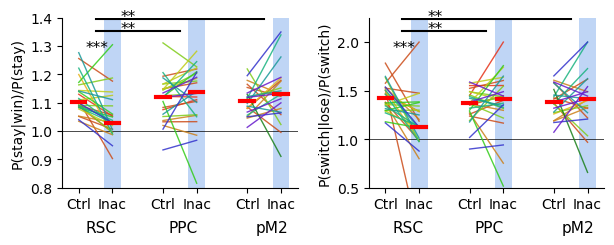

In [ ]:
f,ax = plt.subplots(1,2, figsize = [7, 2.5], tight_layout=False)
# corrected _ctrl to _ctrl_prime 6/17
ax[0].plot([-1,7.5],[1,1],'-k',linewidth=0.5)
plot_wsls_pairs_mixedeffects(ax[0], [0.8,1.4], chr2_ws_ls, 'ws_stay_ctrl_prime', 'ws_stay_opto_prime')
ax[0].set_ylabel('P(stay|win)/P(stay)', fontsize=10)

ax[1].plot([-1,7.5],[1,1],'-k',linewidth=0.5)
plot_wsls_pairs_mixedeffects(ax[1], [0.5,2.25], chr2_ws_ls, 'ls_switch_ctrl_prime', 'ls_switch_opto_prime')
ax[1].set_ylabel('P(switch|lose)/P(switch)', fontsize=10)

ax[0].plot([1.5,4.0],[1.355, 1.355],'-k',linewidth=1.5)
ax[0].plot([1.5,6.5],[1.395,1.395],'-k',linewidth=1.5)
ax[1].plot([1.5,4.0],[2.115, 2.115],'-k',linewidth=1.5)
ax[1].plot([1.5,6.5],[2.235, 2.235],'-k',linewidth=1.5) 

plt_remove_spines(ax)
f.subplots_adjust(left=None, bottom=0.2, right=None, top=None, wspace=0.3, hspace=None)
# f.savefig(pjoin(fig_save_dir,'4_opto','ws_stay_ls_switch_prime_ChR2_across_area.png'))
# f.savefig(pjoin(fig_save_dir,'4_opto','ws_stay_ls_switch_prime_ChR2_across_area.svg'))

### Behlogits

#### Load behlogit data

In [100]:
# Load server data
behlogit_df = pd.read_pickle(pjoin(opto_dir, 'opto_behlogit_RA_10hist.pkl'))

#### [Plt] Delta loglik, stats opto v ctrl

[0.00390625 0.359375   0.49609375]
Medians: 0.01489 -0.00192 0.01513 0.01644 0.01791 0.01900
p values without multicompare are: 0.004 0.359 0.496
p values with holm-bonferoni are: 0.012 0.719 0.719
p values with bonferoni are: 0.012 1.000 1.000
p values with fdr are: 0.012 0.496 0.496
RSC:PPC 0.01942, RSC:M2 0.03370


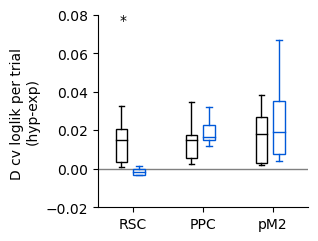

In [101]:
f,ax = plt.subplots(1,1,  figsize = [3.5, 2.5], tight_layout=False)
# Delta hyp-exp
out_df = behlogit_df.copy()
ax.plot([0,12], [0,0], c='grey', linewidth=1)
c_delta_rsc = out_df.loc[((out_df['Area']=='RSCb')),'median_ctrl_dll_trial'].values
plot_boxplot(ax,1,c_delta_rsc,'k')
o_delta_rsc = out_df.loc[((out_df['Area']=='RSCb')),'median_opto_dll_trial'].values
plot_boxplot(ax,1.75,o_delta_rsc,plt_colors['opto'])

c_delta_ppc = out_df.loc[((out_df['Area']=='PPCb')),'median_ctrl_dll_trial'].values
plot_boxplot(ax,4,c_delta_ppc,'k')
o_delta_ppc = out_df.loc[((out_df['Area']=='PPCb')),'median_opto_dll_trial'].values
plot_boxplot(ax,4.75,o_delta_ppc,plt_colors['opto'])

c_delta_m2 = out_df.loc[((out_df['Area']=='M2b')),'median_ctrl_dll_trial'].values
plot_boxplot(ax,7,c_delta_m2,'k')
o_delta_m2 = out_df.loc[((out_df['Area']=='M2b')),'median_opto_dll_trial'].values
plot_boxplot(ax,7.75,o_delta_m2,plt_colors['opto'])
ax.set_ylabel('D cv loglik per trial \n(hyp-exp)')

# pval, sig_lvl, h_norm, pos_neg = stats_compare(delta_rsc); pval_vec = pval
pval, sig_lvl, pos_neg = stats_wilcoxon(o_delta_rsc-c_delta_rsc); pval_vec = pval
pval, sig_lvl, pos_neg = stats_wilcoxon(o_delta_ppc-c_delta_ppc); pval_vec = np.append(pval_vec,pval)
pval, sig_lvl, pos_neg = stats_wilcoxon(o_delta_m2-c_delta_m2); pval_vec = np.append(pval_vec,pval)
print(pval_vec)

medians_vec = np.array([np.median(c_delta_rsc), np.median(o_delta_rsc),  
                        np.median(c_delta_ppc), np.median(o_delta_ppc), 
                        np.median(c_delta_m2), np.median(o_delta_m2)])
print('Medians: {0:.5f} {1:.5f} {2:.5f} {3:.5f} {4:.5f} {5:.5f}'.format(*medians_vec))
_,pval_bh,_,_ = sm.stats.multitest.multipletests(pval_vec, alpha=0.05,method='h')
_,pval_b,_,_ = sm.stats.multitest.multipletests(pval_vec, alpha=0.05,method='b')
_,pval_fdr,_,_ = sm.stats.multitest.multipletests(pval_vec, alpha=0.05,method='fdr_bh')
print('p values without multicompare are: {0:.3f} {1:.3f} {2:.3f}'.format(*pval_vec))
print('p values with holm-bonferoni are: {0:.3f} {1:.3f} {2:.3f}'.format(*pval_bh))
print('p values with bonferoni are: {0:.3f} {1:.3f} {2:.3f}'.format(*pval_b))
print('p values with fdr are: {0:.3f} {1:.3f} {2:.3f}'.format(*pval_fdr))

add_sig_plt(ax,.1,.95,10,pval_fdr[0],-1,0)
add_sig_plt(ax,.42,.95,10,pval_fdr[1],-1,0)
add_sig_plt(ax,.82,.95,10,pval_fdr[2],-1,0)

rsc_delta_delta = (o_delta_rsc-c_delta_rsc)
ppc_delta_delta = (o_delta_ppc-c_delta_ppc)
m2_delta_delta = (o_delta_m2-c_delta_m2)

_,p_rsc_ppc = stats.ttest_ind(rsc_delta_delta, ppc_delta_delta)
_,p_rsc_m2 = stats.ttest_ind(rsc_delta_delta, m2_delta_delta)
print('RSC:PPC {0:.5f}, RSC:M2 {1:.5f}'.format(p_rsc_ppc, p_rsc_m2))
    

ax.set_xlim([0,9])
ax.set_ylim([-0.02, 0.08])
ax.set_xticks([1.5, 4.5, 7.5])
ax.set_xticklabels(['RSC','PPC','pM2'],rotation=0)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
f.subplots_adjust(left=0.3, bottom=None, right=None, top=None, wspace=None, hspace=None)
# f.savefig(pjoin(fig_save_dir,'4_opto','acrossarea_deltaloglik_wilcoxon.png'))
# f.savefig(pjoin(fig_save_dir,'4_opto','acrossarea_deltaloglik_wilcoxon.svg'))